# loop on twin color pairs  with multi colors

- author Sylvie Dagoret-Campagne
- creation date 2024-06-22
- last update 2024-06-22
- affiliation : IJCLab
- Kernel **w_2024_16**

- 1) Start by two-objects-lists sources in different bands. Thowe object are close enough to expect their visit in same calexp frequently
- 2) **Merge above visits lists**  in same band/same calexp for object 1 and Object 2 : df_g, df_r, df_z, df_y
- 3) Find closest time visit in other bands : dfg_r,

In [1]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor=None, alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [3]:
import gc

In [4]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time
import scipy

In [5]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [6]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

#import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle
import lsst.sphgeom

In [7]:

from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure

In [8]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [9]:
transform = AsinhStretch() + PercentileInterval(99.)

In [10]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240513/w_2024_20/PREOPS-5146' # test this one today 2024/06/22

collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
patch_sel = 236
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [11]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [12]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=collections)

## Definition of functions used

In [13]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [14]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [15]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [16]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [17]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

In [18]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [19]:
def find_neighbourg(ra0,dec0,src):
    """ 
    Calculate the angular separation of a list of sources in src pandas table from a (ra0,dec0) source location
    """
    all_angles = []
    for index, row in src.iterrows():
        spherePointCenter = lsst.geom.SpherePoint(ra0*lsst.geom.degrees, dec0*lsst.geom.degrees)
        spt = lsst.geom.SpherePoint(row["ra"]*lsst.geom.degrees, row["dec"]*lsst.geom.degrees)
        ang = spherePointCenter.separation(spt)
        ang_arcsec = ang.asArcseconds()
        all_angles.append(ang_arcsec)
    return all_angles

In [20]:
def PlotAndFitHisto(data,std_clip,ax,nbins=50,xlabel=r'$(G-R)_1 - (G-R)_2$ :',title="Differential color with 2 stars",xmin=-100.,xmax=100.):
    #data = df_col_gr["ratio3"].values

    hist, bin_edges = np.histogram(data,bins=nbins,range=(xmin,xmax),density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., 0., 1.]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)

    textstr = '\n'.join((
    xlabel,
    r'$\sigma_{clipped} = %.01f$ mmag' %(std_clip,),
    r'$\sigma_{fit} = %.01f$ mmag' %(coeff[2], )))

    ax.step(bin_centres, hist,'k' ,label='data')
    ax.plot(bin_centres, hist_fit,'r-', label='fit')
    ax.set_xlabel(xlabel)
    ax.legend()
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="blue", weight='bold',bbox=props)
    ax.set_title(title)
    ax.set_xlim(xmin,xmax)
    # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
    #print('Fitted mean = ', coeff[1])
    #print('Fitted standard deviation = ', coeff[2])

In [21]:
def closestvisit(df1,df2):
    """
    This function associate pairs of closest observation

    input : the 2 dataframes (first to one for which one want to find the closest obs in dtaframe 2)
    output : the dataframe of similar format as the first one having columns on nightobs , visit time, dt from second dataframe)
    """
    d1 =df1.copy(deep=True)
    d2 =df2.copy(deep=True)
    all_samples = []
    df = pd.DataFrame(index=d1.index,columns=["nightObs2","visit2","time2","deltat"])
    for key in d1.index:

        nightObs = key[0]
        time1 = d1.loc[key]["time"]
        d2["dt"] = np.abs(d2["time"]-time1)
        d2["Dt"] = d2["time"]-time1
        cut_sel = (d2["dt"] == d2["dt"].min()) #& (d2["nightObs"] == nightObs)
        sample = d2[cut_sel]
        #df.iloc[key] = [sample.index[0][0],sample.index[0][1],sample["time"].values[0],sample['dt'].values[0]]
        df.loc[key]["nightObs2"] = sample.index[0][0]
        df.loc[key]["visit2"] = sample.index[0][1]
        df.loc[key]["time2"] = sample["time"].values[0]
        df.loc[key]["deltat"] = pd.to_timedelta(sample["Dt"].values[0], unit="s").total_seconds()
        all_samples.append(sample)

    # select observations during the same night
    df_back = df.copy(deep=True)
    flag_sel = []
    for key in df_back.index:
        nightObs = key[0]
        nightObs2 = df_back.loc[key]["nightObs2"]
        flag_sel.append(nightObs == nightObs2)
    df = df[flag_sel]
    return df

In [22]:
def getcutoutandimage(visitId,df_selectedvisits):
    """
    visitId : the calexp where are the two stars
    df_selectedvisits : the list of all sources and visit of the main targeted star
    """

    row_source = df_selectedvisits[df_selectedvisits.visit == visitId].iloc[0]  
    band = row_source['band']

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)   
    src_cat = butler.get('sourceTable',**dataId, collections=collections)

    #select on star
    #src_cat = src_cat[(src_cat["extendedness"]==0) & (src_cat["parentSourceId"] == 0) ]
    #src_cat = src_cat[src_cat["extendedness"]==0 ]

    x1 = row_source['x_x']
    y1 = row_source['y_x']
    ra1= row_source['ra_x']
    dec1= row_source['dec_x']
    psfMag1  = row_source['psfMag_x']  
    psfSigma1 = row_source['psfSigma_x']
    psfMagDiffMmag1 = row_source['psfMagDiffMmag_x'] 
    apFlux_50_0_instFlux1 = row_source['apFlux_50_0_instFlux_x']
    apFlux_50_0_instFluxErr1 = row_source['apFlux_50_0_instFluxErr_x']


    x2 = row_source['x_y']
    y2 = row_source['y_y']
    ra2= row_source['ra_y']
    dec2= row_source['dec_y']
    psfMag2  = row_source['psfMag_y']  
    psfSigma2 = row_source['psfSigma_y']
    psfMagDiffMmag2 = row_source['psfMagDiffMmag_y'] 
    apFlux_50_0_instFlux2 = row_source['apFlux_50_0_instFlux_y']
    apFlux_50_0_instFluxErr2 = row_source['apFlux_50_0_instFluxErr_y']

    
    # searcch the neighbouring stars
    #separation = find_neighbourg(ra_target,dec_target,src_cat)
    #src_cat["sep"] = separation


    spherePointCenter = lsst.geom.SpherePoint(ra1*lsst.geom.degrees, dec1*lsst.geom.degrees)
    spt = lsst.geom.SpherePoint(ra2*lsst.geom.degrees, dec2*lsst.geom.degrees)
    ang = spherePointCenter.separation(spt)
    ang_arcsec = ang.asArcseconds()
    
   
    x0 = (x1+x2)/2.
    y0 = (y1+y2)/2.
    ra0 = (ra1+ra2)/2.
    dec0 = (dec1+dec2)/2.
    

    dx1 = x1-x0
    dy1 = y1-y0
    dx2 = x2-x0
    dy2 = y2-y0
    
    
    boxSize = int(max(np.abs(x1-x2),np.abs(y1-y2)))
    xmin= x0-boxSize
    xmax= x0+boxSize
    ymin= y0-boxSize
    ymax= y0+boxSize
        
    
    minBbox = geom.Point2I(int(x0) - boxSize ,int(y0) - boxSize)
    maxBbox = geom.Point2I(int(x0) + boxSize, int(y0) + boxSize)
    
    srcBbox = geom.Box2I(minBbox, maxBbox)


    row_source['x0'] = x0
    row_source['y0'] = y0
    row_source['xmin'] = xmin
    row_source['ymin'] = ymin
    row_source['xmax'] = xmax
    row_source['ymax'] = ymax
    row_source['ra0'] = ra0
    row_source['dec0'] = dec0

    row_source['x1'] = x1
    row_source['y1'] = y1
    row_source['dx1'] = dx1
    row_source['dy1'] = dy1
    row_source['ra1'] = ra1
    row_source['dec1'] = dec1

    row_source['x2'] = x2
    row_source['y2'] = y2
    row_source['dx2'] = dx2
    row_source['dy2'] = dy2
    row_source['ra2'] = ra2
    row_source['dec2'] = dec2
    
    
    # Make the cutout
    try:
        subimg = afwImage.ExposureF(calexp, srcBbox, afwImage.PARENT, True)
        #subimg2 = calexp.getImage().array[int(ySrc) - boxSize: int(ySrc) + boxSize+1, int(xSrc) - boxSize:int(xSrc) + boxSize+1 ]
        #subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)
        #all_cutout.append(subimgRgb)
        cutout=subimg.image.array
        
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)     
        cutout = None

    df_pair = row_source.to_frame()
    return row_source,cutout



In [23]:
def plotfullcalexp(row_pair,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
    else:
        flag_ax = True

    band = 0
    ra = 0
    dec = 0

    x0 = row_pair["x0"]
    y0 = row_pair["y0"]
    
    visitId = row_pair["visit"]
    band = row_pair["band"]
    psfMag1 = row_pair["psfMag_x"]
    psfSigma1 = row_pair["psfSigma_x"]
    x1 = row_pair["x1"]
    y1 = row_pair["y1"]
    ra1 = row_pair['ra2']
    dec1 = row_pair['dec2']
    ann1 = Annulus((x1,y1),r=5*psfSigma1,width=0.1,color="r")
    ax.add_patch(ann1)

  
    psfMag2 = row_pair["psfMag_y"]
    psfSigma2 = row_pair["psfSigma_y"]
    x2 = row_pair["x2"]
    y2 = row_pair["y2"]
    ra2 = row_pair['ra2']
    dec2 = row_pair['dec2']
    ann2 = Annulus((x2,y2),r=5*psfSigma2,width=0.1,color="orange")
    ax.add_patch(ann2)

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)
    imgarr = calexp.image.array 
    shape =  imgarr.shape
    #extent = [x0-shape[1]/2., x0+shape[1]/2., y0-shape[0]/2., y0+shape[0]/2.]
   
    z = ZScaleInterval()
    z1,z2 = z.get_limits(imgarr)
    im = ax.imshow(imgarr,origin="lower",cmap="grey",vmin=z1, vmax=z2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    plt.colorbar(im, cax=cax)

    
    title = f"calexp {visitId}, objidx:{objectname1},{objectname2} band :{band}"
    ax.set_title(title)
    ax.axvline(x0,color="w",linestyle=":")
    ax.axhline(y0,color="w",linestyle=":")
    

    textstr = '\n'.join((
    r'$exposure = %.0f$' % (visitId, ),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$ra_1 = %f deg $' %(ra1,),
    r'$ra_2 = %f deg $' %(ra2,),  
    r'$dec_1 = %f deg $' %(dec1,),
    r'$dec_2 = %f deg $' %(dec2,)))  
  

    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="y", weight='bold',bbox=props) 
    #if flag_deblend_skipped:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="r", weight='bold',bbox=props) 
    #else:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="g", weight='bold',bbox=props) 

    if not flag_ax:
        plt.show()   

In [24]:
def plotcutout(row_pair,cutout,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,5))
    else:
        flag_ax = True

    if cutout is None:
        print("No Cutout")
        return

    boxSize= cutout.shape[0]//2
    extent = [ row_pair['xmin'], row_pair['xmax'], row_pair['ymin'], row_pair['ymax']]
    
    z = ZScaleInterval()
    z1,z2 = z.get_limits(cutout)
    im = ax.imshow(cutout,origin='lower',cmap="grey",vmin=z1, vmax=z2,extent = extent)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    #plt.colorbar(im, cax=cax)

  

    band = 0
    ra = 0
    dec = 0
    
  
    visitId = row_pair["visit"]
    band = row_pair["band"]
    psfMag1 = row_pair["psfMag_x"]
    psfSigma1 = row_pair["psfSigma_x"]
    x1 = row_pair["x1"]
    y1 = row_pair["y1"]
    ra1 = row_pair['ra1']
    dec1 = row_pair['dec1']
    ann1 = Annulus((x1,y1),r=3*psfSigma1,width=0.1,color="r")
    ax.add_patch(ann1)

  
    psfMag2 = row_pair["psfMag_y"]
    psfSigma2 = row_pair["psfSigma_y"]
    x2 = row_pair["x2"]
    y2 = row_pair["y2"]
    
    ann2 = Annulus((x2,y2),r=3*psfSigma2,width=0.1,color="orange")
    ax.add_patch(ann2)
    
    #title = f"obj:{objectname}, b:{band}, (ra:{ra:.2f}, dec:{dec:.2f})"
    #ax.set_title(title)

    textstr = '\n'.join((
    r'$expos = %.0f$' % (visitId, ),
    r'$band  = %s $' % (band,),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$\sigma_{PSF} = %.2f pix$' % (psfSigma1 , )))
   
  
    ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="orange", weight='bold',bbox=props) 


    
    if not flag_ax:
        plt.show()   

In [25]:
def GetFluxes2StarsTwoBands(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    Extract color difference from two bright object sources.
    band1 : first band tag 
    band2 : second band tag
    dfb1_b2 : pandas dataframe associating visit in band 1 to visit in band 2
    df_selectedvisits_b1: sources for object 1 and 2 in band 1
    df_selectedvisits_b2: sources for object 1 and 2 in band 2
    May plot some calexp cutout for checking
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt"])
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])



            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt]
            entrycount+=1

        
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)
            continue
      

        if idx%10 == 0:
            if cutoutb1 is not None and cutoutb2 is not None:
                NROWS = 1
                NCOLS = 2
                fig, (ax1,ax2) = plt.subplots(ncols=NCOLS,nrows=NROWS,figsize=(6*NCOLS,6*NROWS))
                plotcutout(row_pair_b1,cutoutb1,ax=ax1)
                plotcutout(row_pair_b2,cutoutb2,ax=ax2)
                plt.show()

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)
    
    return df_col_b1b2


In [26]:
def GetFluxes2StarsTwoBandsNoCutout(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    Extract color difference from two bright object sources.
    band1 : first band tag 
    band2 : second band tag
    dfb1_b2 : pandas dataframe associating visit in band 1 to visit in band 2
    df_selectedvisits_b1: sources for object 1 and 2 in band 1
    df_selectedvisits_b2: sources for object 1 and 2 in band 2
    NO NOT plot some calexp cutout contrary to above function
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt"])
    
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            #row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            #row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 
            row_pair_b1  = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]  
            row_pair_b2  = df_selectedvisits_b2[df_selectedvisits_b2.visit == visit2].iloc[0]  

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]    
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
              
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])



            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt]

            entrycount+=1
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)
            continue

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # absolute relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = np.abs(df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"])
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = np.abs(df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"])
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)


    return df_col_b1b2

## Get Pixel Scale

In [27]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)

In [28]:
tWCS

FITS standard SkyWcs:
Sky Origin: (122.4365482234, -36.4462809917)
Pixel Origin: (28499, 28499)
Pixel Scale: 0.1 arcsec/pixel

In [29]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

### Spectroscopy

In [30]:
atmfilename = "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy"

In [31]:
specdata = np.load(atmfilename,allow_pickle=True)

In [32]:
df_spec = pd.DataFrame(specdata)
df_spec

,DATE-OBS,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,D2CCD,LSHIFT,PARANGLE,TARGETX,TARGETY,LBDA_REF,PSF_REG,TRACE_R,MEANFWHM,PIXSHIFT,CHI2_FIT,A2_FIT,AM_FIT,VERSION,CCD_REBIN,CONFIG,EXPTIME,AIRMASS,DEC,HA,OUTTEMP,OUTPRESS,OUTHUM,FILTER,CAM_ROT,S_X0,S_Y0,S_XMIN,S_XMAX,S_YMIN,S_YMAX,S_NX,S_NY,S_DEG,S_SAT,S_ORDER,A1_x,A1_err_x,A2_x,A2_err_x,A3,A3_err,VAOD_x,VAOD_err_x,angstrom_exp_x,angstrom_exp_err_x,ozone [db]_x,ozone [db]_err_x,PWV [mm]_x,PWV [mm]_err_x,B_x,B_err_x,A_star,A_star_err,D_CCD [mm]_x,D_CCD [mm]_err_x,shift_x [pix],shift_x [pix]_err,shift_y [pix],shift_y [pix]_err,angle [deg],angle [deg]_err,x_c_0_1,x_c_0_1_err,x_c_1_1,x_c_1_1_err,x_c_2_1,x_c_2_1_err,y_c_0_1,y_c_0_1_err,y_c_1_1,y_c_1_1_err,y_c_2_1,y_c_2_1_err,gamma_0_1,gamma_0_1_err,gamma_1_1,gamma_1_1_err,gamma_2_1,gamma_2_1_err,alpha_0_1,alpha_0_1_err,alpha_1_1,alpha_1_1_err,alpha_2_1,alpha_2_1_err,saturation_0_1,saturation_0_1_err,x_c_0_2,x_c_0_2_err,x_c_1_2,x_c_1_2_err,x_c_2_2,x_c_2_2_err,y_c_0_2,y_c_0_2_err,y_c_1_2,y_c_1_2_err,y_c_2_2,y_c_2_2_err,gamma_0_2,gamma_0_2_err,gamma_1_2,gamma_1_2_err,gamma_2_2,gamma_2_2_err,alpha_0_2,alpha_0_2_err,alpha_1_2,alpha_1_2_err,alpha_2_2,alpha_2_2_err,saturation_0_2,saturation_0_2_err,x_c_0_3,x_c_0_3_err,x_c_1_3,x_c_1_3_err,x_c_2_3,x_c_2_3_err,y_c_0_3,y_c_0_3_err,y_c_1_3,y_c_1_3_err,y_c_2_3,y_c_2_3_err,gamma_0_3,gamma_0_3_err,gamma_1_3,gamma_1_3_err,gamma_2_3,gamma_2_3_err,alpha_0_3,alpha_0_3_err,alpha_1_3,alpha_1_3_err,alpha_2_3,alpha_2_3_err,saturation_0_3,saturation_0_3_err,A1_y,A1_err_y,A2_y,A2_err_y,VAOD_y,VAOD_err_y,angstrom_exp_y,angstrom_exp_err_y,ozone [db]_y,ozone [db]_err_y,PWV [mm]_y,PWV [mm]_err_y,reso [nm],reso [nm]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
0,2023-01-18 02:33:44.320492641+00:00,2023011700238,-64,2,1136,3,True,HD185975,-0.000065,holo4_003,0.149105,187.115733,0.0,139.709895,146.034375,882.149820,619.643455,14.563485,93.783944,10.355760,1.160026,10.840887,0.0,2.094160,3.1.0,2,,30.0,2.094160,-87.507430,-221.203268,10.00,743.00,NaN,empty,41.849028,-417.516831,19.149820,560,1696,863,908,1136,45,2,22666.666667,1,0.664441,0.005724,1.0,0.0,0.0,0.0,0.050687,0.004121,0.303824,0.028039,359.623063,1.770352,4.483119,0.020971,1.0,0.0,1.0,0.0,187.034266,0.008275,1.277989,0.041836,-0.193538,0.0,0.139924,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,-0.035756,0.000813,0.020469,0.001938,0.315324,0.004637,15.322203,0.015657,-4.534772,0.016222,-13.475017,0.036052,5.494988,0.008192,-0.822629,0.006912,-5.679592,0.016640,22666.666667,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,0.362173,0.177561,-2.036786,0.642700,-3.179989,0.568601,28.027856,0.970177,0.0,0.0,0.0,0.0,10.000000,0.602072,0.0,0.0,0.0,0.0,22666.666667,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.023469,0.0,0.0,0.0,0.0,0.0,8.988875,0.0,0.0,0.0,0.0,0.0,22666.666667,0.0,0.735193,0.701231,0.0,0.0,0.094037,0.459493,0.181265,0.997354,382.709734,9.364816,4.971505,0.064734,1.024480,0.027735,187.113505,0.004147,1.160026,0.0,0.0,0.0
1,2023-01-18 02:34:27.138506292+00:00,2023011700239,-64,2,1137,3,True,HD185975,-0.000065,holo4_003,0.138871,187.076469,0.0,139.885619,144.051156,882.564567,619.643455,0.228823,53.345136,10.918251,0.101144,4.849593,0.0,2.094525,3.1.0,2,,30.0,2.094525,-87.507439,-221.024162,10.00,743.00,NaN,empty,41.849066,-417.179307,19.564567,559,1696,863,908,1137,45,2,22666.666667,1,0.606995,0.000447,1.0,0.0,0.0,0.0,0.000000,0.000446,1.275747,0.000000,266.588883,1.690057,3.330756,0.018129,1.0,0.0,1.0,0.0,187.330383,0.004054,0.136300,0.009280,-0.058637,0.0,0.138740,0.0,985.285378,0.0,568.022658,0.0,-0.022383,0.0,-0.130373,0.000763,0.008003,0.002190,1.141302,0.004924,11.201134,0.010199,-0.512261,0.026190,3.048078,0.058986,3.454636,0.003848,0.508409,0.011071,1.073220,0.023461,22666.666667,0.0,985.285378,0.0,568.022658,0.0,-0.022383,0.0,-0.349097,0.155047,-5.994891,0.536350,-8.025680,0.457910,11.666854,0.096594,0.0,0.0,0.0,0.0,3.321643,0.034542,0.0,0.0,0.0

In [33]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])
#df_spec["PWV [mm]_x"]

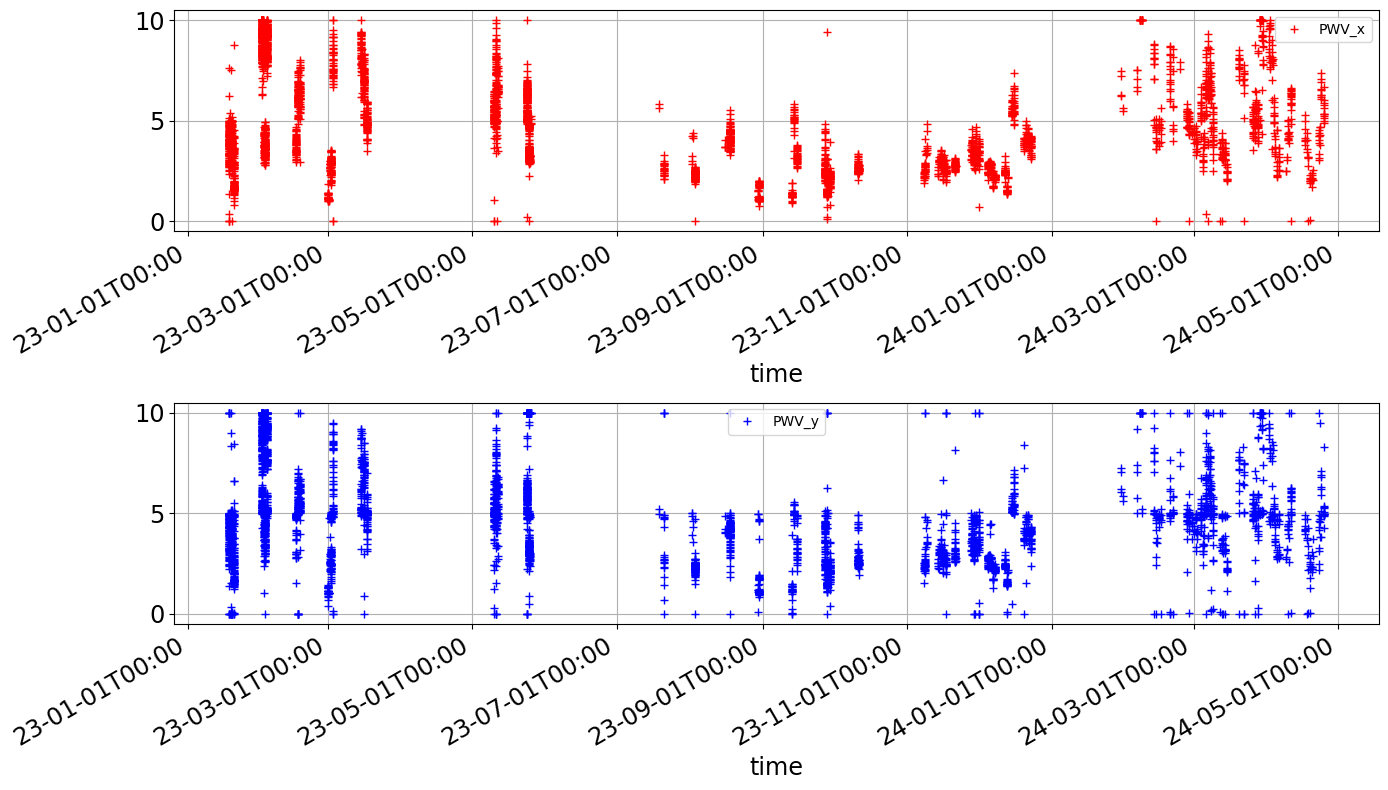

In [34]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8))
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="PWV_x")
df_spec.plot(x="Time",y="PWV [mm]_y",ax=ax2,marker='+',c="b",lw=0.0,grid=True,label="PWV_y")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)
plt.tight_layout()

## Photometry

#### read list of all possible pairs

In [35]:
df_pair = pd.read_csv("all_pairs.csv",index_col=0)
df_pair.head()

,objidx1,objidx2,G1_R1,G2_R2,Z1_Y1,Z2_Y2,sep
694,158.0,910.0,0.739111,0.987084,-0.116571,NaN,7.954936
1893,617.0,647.0,0.543391,0.347490,-0.203188,-0.020987,10.576022
379,121.0,240.0,0.545134,0.151336,-0.111061,0.007964,16.130015
2049,882.0,954.0,0.867764,1.373554,-0.174242,NaN,16.857574
16,60.0,240.0,0.483214,0.151336,-0.088688,0.007964,18.286541


Text(0.5, 1.0, 'Bright sources angular correlation in tract 3864')

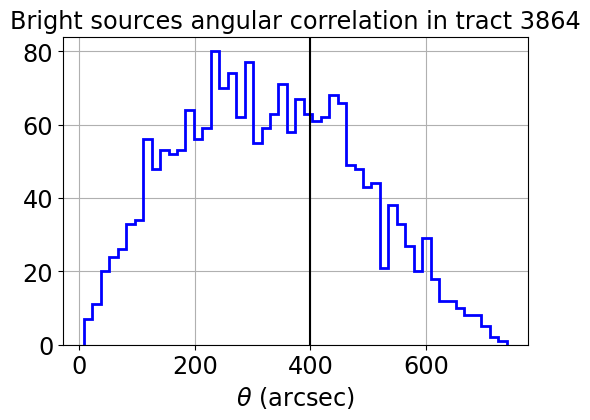

In [36]:
fig,axs = plt.subplots(1,1,figsize=(6,4))
ax1 = axs
df_pair["sep"].hist(bins=50,ax=ax1,histtype="step",color="b",lw=2);
image_size = 0.1*4000.
ax1.axvline(image_size,color="k")
ax1.set_xlabel("$\\theta$ (arcsec)")
ax1.set_title(f"Bright sources angular correlation in tract {tract}")


### Read All sources from all objects 

In [37]:
#inputfilename = "sources_objectTable-t3864-multibands-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv"

## The two lists:
path_photom ="data/photom/sources_objectTable"
tract = 3864

inputfilename ="objects-lightcurves-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069-tract3864.csv"
inputfullfilename= os.path.join(path_photom,inputfilename) 

df_allsources = pd.read_csv(inputfullfilename,index_col=0)


In [38]:
df_allsources.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
0,179300073413279749,1.590427e+06,12951.962007,False,1.019180,0.0,0.0,True,False,1.627483e+06,16530.075939,False,45.186953,0.090804,False,4,2023121500478,0,122.616310,-36.190488,SDSSz_65mm~empty,z,35957.226770,617.848502,3577.161135,50.744859,37554.299549,870.651580,False,0.285867,False,4,526,122.794318,15.896215,0.008842,1.624798e+06,27918.691042,15.873002,0.018656,1.696964e+06,39342.091752,15.825818,0.025171,20.033748,0.008842,0.977231,42748468736,2023121500478,z,21.00044,27.282501,4.202831,13.336939,8.06057,0.027859,0.011082,62,-0.000778,-0.002066,0.015893,0.00986,0.010462,0.077073,0.0184,0.544138,2171.611,0.284355,0.056613,2.249392,0.074432,-36.139215,0,0.947236,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.002208,0.051613,-0.051273,-307.066273,-7.029632,41.469376,-13.767346,16.766397,27.262467,0.002182,-0.020034
1,179300073413279764,1.745098e+06,14092.440598,False,1.011197,0.0,0.0,True,False,1.740110e+06,16045.611396,False,44.329708,0.090804,False,19,2023121500478,0,122.585459,-36.189035,SDSSz_65mm~empty,z,38141.482273,714.174432,2641.422154,117.690669,36552.223725,1007.246250,False,-0.151407,False,19,214,123.832235,15.795450,0.008768,1.690801e+06,31659.144081,15.829769,0.020330,1.620349e+06,44650.932225,15.875978,0.029919,19.912187,0.008768,1.002867,42748468736,2023121500478,z,21.00044,27.282501,4.202831,13.336939,8.06057,0.027859,0.011082,62,-0.000778,-0.002066,0.015893,0.00986,0.010462,0.077073,0.0184,0.544138,2171.611,0.284355,0.056613,2.249392,0.074432,-36.139215,0,0.947236,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.002208,0.020762,-0.049820,-204.374556,-6.497087,-3.833432,-3.030562,-5.247383,27.283263,0.002224,0.000762
2,179300073413279802,1.067822e+07,35280.151488,False,1.009686,0.0,0.0,True,False,1.072051e+07,39778.909003,False,45.241491,0.090804,False,57,2023121500478,0,122.614697,-36.183513,SDSSz_65mm~empty,z,236931.399443,805.869427,3531.742458,313.696502,241060.843626,1040.035058,False,1.079774,False,57,647,302.669445,13.828752,0.003587,1.071913e+07,36458.734594,13.824601,0.003693,1.090595e+07,47052.736895,13.805841,0.004684,17.967595,0.003587,0.996056,42748468736,2023121500478,z,21.00044,27.282501,4.202831,13.336939,8.06057,0.027859,0.011082,62,-0.000778,-0.002066,0.015893,0.00986,0.010462,0.077073,0.0184,0.544138,2171.611,0.2

### Select the pairs

In [39]:
sep_max = 100.
df_pair = df_pair[df_pair["sep"]<sep_max]

Text(0.5, 1.0, 'Bright sources angular correlation in tract 3864')

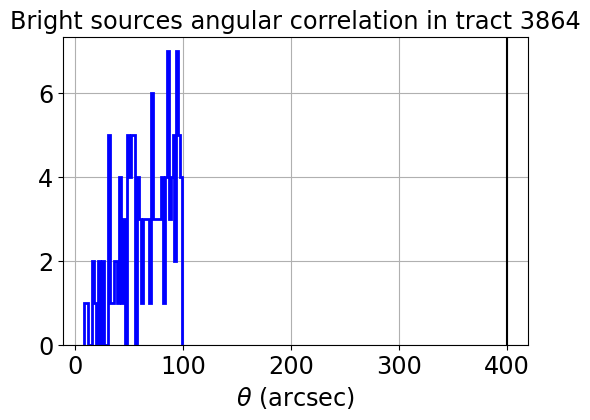

In [40]:
fig,axs = plt.subplots(1,1,figsize=(6,4))
ax1 = axs
df_pair["sep"].hist(bins=50,ax=ax1,histtype="step",color="b",lw=2);
image_size = 0.1*4000.
ax1.axvline(image_size,color="k")
ax1.set_xlabel("$\\theta$ (arcsec)")
ax1.set_title(f"Bright sources angular correlation in tract {tract}")

## Loop on pairs

In [ ]:
all_colors_diff = []
for idx_pair  in range(len(df_pair)):

    objectname1 = int(df_pair["objidx1"].iloc[idx_pair])
    objectname2 = int(df_pair["objidx2"].iloc[idx_pair])
    print(f"==================== {idx_pair}) :: ===== {objectname1}, {objectname2} ====== ")
    #print(df_pair.iloc[idx_pair])

    #### Select all sources/visits corresponding to object1/object2 respectively
    df_myselectedvisits1 = df_allsources[df_allsources.obj_index==objectname1] 	
    df_myselectedvisits2 = df_allsources[df_allsources.obj_index==objectname2] 	

    #### sort according increasing visit number
    df_myselectedvisits1.sort_values("visit",inplace=True)
    df_myselectedvisits2.sort_values("visit",inplace=True)

    #### Compute nightobs and Times (pd.to_datetime)
    df_myselectedvisits1["nightObs"] = df_myselectedvisits1.apply(lambda x: x['visit']//100_000 , axis=1)
    df_myselectedvisits1["Time"] = pd.to_datetime(df_myselectedvisits1['obsStart'])

    df_myselectedvisits2["nightObs"] = df_myselectedvisits2.apply(lambda x: x['visit']//100_000 , axis=1)
    df_myselectedvisits2["Time"] = pd.to_datetime(df_myselectedvisits2['obsStart'])

    #### Split list by bands
    df_myselectedvisits_g1 = df_myselectedvisits1[df_myselectedvisits1.band == "g"]
    df_myselectedvisits_r1 = df_myselectedvisits1[df_myselectedvisits1.band == "r"]
    df_myselectedvisits_z1 = df_myselectedvisits1[df_myselectedvisits1.band == "z"]
    df_myselectedvisits_y1 = df_myselectedvisits1[df_myselectedvisits1.band == "y"]

    df_myselectedvisits_g2 = df_myselectedvisits2[df_myselectedvisits2.band == "g"]
    df_myselectedvisits_r2 = df_myselectedvisits2[df_myselectedvisits2.band == "r"]
    df_myselectedvisits_z2 = df_myselectedvisits2[df_myselectedvisits2.band == "z"]
    df_myselectedvisits_y2 = df_myselectedvisits2[df_myselectedvisits2.band == "y"]

    #### Merge visits in same band/same calexp for object 1 and Object 2 
    df_y = df_myselectedvisits_y1.merge(df_myselectedvisits_y2, left_on='visit', right_on='visit',how="inner")
    df_z = df_myselectedvisits_z1.merge(df_myselectedvisits_z2, left_on='visit', right_on='visit',how="inner")
    df_g = df_myselectedvisits_g1.merge(df_myselectedvisits_g2, left_on='visit', right_on='visit',how="inner")
    df_r = df_myselectedvisits_r1.merge(df_myselectedvisits_r2, left_on='visit', right_on='visit',how="inner")

    #### Rename quantities supposed to be the same as same visit
    df_y["band"] = df_y["band_x"]
    df_z["band"] = df_z["band_x"]
    df_g["band"] = df_g["band_x"]
    df_r["band"] = df_r["band_x"]

    df_y["Time"] = df_y["Time_x"]
    df_z["Time"] = df_z["Time_x"]
    df_g["Time"] = df_g["Time_x"]
    df_r["Time"] = df_r["Time_x"]

    df_y["nightObs"] = df_y["nightObs_x"]
    df_z["nightObs"] = df_z["nightObs_x"]
    df_g["nightObs"] = df_g["nightObs_x"]
    df_r["nightObs"] = df_r["nightObs_x"]

    #df_y["visit"] = df_y["visit_x"]
    #df_z["visit"] = df_z["visit_x"]
    #df_g["visit"] = df_g["visit_x"]
    #df_r["visit"] = df_r["visit_x"]

    df_y["expMidptMJD"] = df_y["expMidptMJD_x"]
    df_z["expMidptMJD"] = df_z["expMidptMJD_x"]
    df_g["expMidptMJD"] = df_g["expMidptMJD_x"]
    df_r["expMidptMJD"] = df_r["expMidptMJD_x"]
    
    #### Difference in magnitudes between the pairs
    df_y["dpsfMag"] = df_y["psfMag_x"] -  df_y["psfMag_y"]
    df_z["dpsfMag"] = df_z["psfMag_x"] -  df_z["psfMag_y"]
    df_g["dpsfMag"] = df_g["psfMag_x"] -  df_g["psfMag_y"]
    df_r["dpsfMag"] = df_r["psfMag_x"] -  df_r["psfMag_y"]
    df_y["dpsfInstMag"] = df_y["psfInstMag_x"] -  df_y["psfInstMag_y"]
    df_z["dpsfInstMag"] = df_z["psfInstMag_x"] -  df_z["psfInstMag_y"]
    df_g["dpsfInstMag"] = df_g["psfInstMag_x"] -  df_g["psfInstMag_y"]
    df_r["dpsfInstMag"] = df_r["psfInstMag_x"] -  df_r["psfInstMag_y"]
    df_y["dpsfMagErr"] = np.sqrt(df_y["psfMagErr_x"]**2 +  df_y["psfMagErr_y"]**2) 
    df_z["dpsfMagErr"] = np.sqrt(df_z["psfMagErr_x"]**2 +  df_z["psfMagErr_y"]**2) 
    df_g["dpsfMagErr"] = np.sqrt(df_g["psfMagErr_x"]**2 +  df_g["psfMagErr_y"]**2) 
    df_r["dpsfMagErr"] = np.sqrt(df_r["psfMagErr_x"]**2 +  df_r["psfMagErr_y"]**2) 
    df_y["dpsfInstMagErr"] = np.sqrt(df_y["psfInstMagErr_x"]**2 +  df_y["psfInstMagErr_y"]**2) 
    df_z["dpsfInstMagErr"] = np.sqrt(df_z["psfInstMagErr_x"]**2 +  df_z["psfInstMagErr_y"]**2) 
    df_g["dpsfInstMagErr"] = np.sqrt(df_g["psfInstMagErr_x"]**2 +  df_g["psfInstMagErr_y"]**2) 
    df_r["dpsfInstMagErr"] = np.sqrt(df_r["psfInstMagErr_x"]**2 +  df_r["psfInstMagErr_y"]**2) 
    df_y["dapFlux_35_0_calMag"] = df_y["apFlux_35_0_calMag_x"] - df_y["apFlux_35_0_calMag_y"]
    df_z["dapFlux_35_0_calMag"] = df_z["apFlux_35_0_calMag_x"] - df_z["apFlux_35_0_calMag_y"]
    df_g["dapFlux_35_0_calMag"] = df_g["apFlux_35_0_calMag_x"] - df_g["apFlux_35_0_calMag_y"]
    df_r["dapFlux_35_0_calMag"] = df_r["apFlux_35_0_calMag_x"] - df_r["apFlux_35_0_calMag_y"]
    df_y["dapFlux_35_0_calMagErr"] = np.sqrt(df_y["apFlux_35_0_calMagErr_x"]**2 + df_y["apFlux_35_0_calMagErr_y"]**2)
    df_z["dapFlux_35_0_calMagErr"] = np.sqrt(df_z["apFlux_35_0_calMagErr_x"]**2 + df_z["apFlux_35_0_calMagErr_y"]**2)
    df_g["dapFlux_35_0_calMagErr"] = np.sqrt(df_g["apFlux_35_0_calMagErr_x"]**2 + df_g["apFlux_35_0_calMagErr_y"]**2)
    df_r["dapFlux_35_0_calMagErr"] = np.sqrt(df_r["apFlux_35_0_calMagErr_x"]**2 + df_r["apFlux_35_0_calMagErr_y"]**2)
    df_y["dapFlux_50_0_calMag"] = df_y["apFlux_50_0_calMag_x"] - df_y["apFlux_50_0_calMag_y"]
    df_z["dapFlux_50_0_calMag"] = df_z["apFlux_50_0_calMag_x"] - df_z["apFlux_50_0_calMag_y"]
    df_g["dapFlux_50_0_calMag"] = df_g["apFlux_50_0_calMag_x"] - df_g["apFlux_50_0_calMag_y"]
    df_r["dapFlux_50_0_calMag"] = df_r["apFlux_50_0_calMag_x"] - df_r["apFlux_50_0_calMag_y"]
    df_y["dapFlux_50_0_calMagErr"] = np.sqrt(df_y["apFlux_50_0_calMagErr_x"]**2 + df_y["apFlux_50_0_calMagErr_y"]**2)
    df_z["dapFlux_50_0_calMagErr"] = np.sqrt(df_z["apFlux_50_0_calMagErr_x"]**2 + df_z["apFlux_50_0_calMagErr_y"]**2)
    df_g["dapFlux_50_0_calMagErr"] = np.sqrt(df_g["apFlux_50_0_calMagErr_x"]**2 + df_g["apFlux_50_0_calMagErr_y"]**2)
    df_r["dapFlux_50_0_calMagErr"] = np.sqrt(df_r["apFlux_50_0_calMagErr_x"]**2 + df_r["apFlux_50_0_calMagErr_y"]**2)
    ##### Relative magnitude difference
    df_y["d_psfMag"] = df_y["dpsfMag"] - df_y["dpsfMag"].mean()
    df_z["d_psfMag"] = df_z["dpsfMag"] - df_z["dpsfMag"].mean()
    df_g["d_psfMag"] = df_g["dpsfMag"] - df_g["dpsfMag"].mean()
    df_r["d_psfMag"] = df_r["dpsfMag"] - df_r["dpsfMag"].mean()
    df_y["d_psfInstMag"] = df_y["dpsfInstMag"] - df_y["dpsfInstMag"].mean()
    df_z["d_psfInstMag"] = df_z["dpsfInstMag"] - df_z["dpsfInstMag"].mean()
    df_g["d_psfInstMag"] = df_g["dpsfInstMag"] - df_g["dpsfInstMag"].mean()
    df_r["d_psfInstMag"] = df_r["dpsfInstMag"] - df_r["dpsfInstMag"].mean()
    df_y["d_apFlux_35_0_calMag"] = df_y["dapFlux_35_0_calMag"] - df_y["dapFlux_35_0_calMag"].mean()
    df_z["d_apFlux_35_0_calMag"] = df_z["dapFlux_35_0_calMag"] - df_z["dapFlux_35_0_calMag"].mean()
    df_g["d_apFlux_35_0_calMag"] = df_g["dapFlux_35_0_calMag"] - df_g["dapFlux_35_0_calMag"].mean()
    df_r["d_apFlux_35_0_calMag"] = df_r["dapFlux_35_0_calMag"] - df_r["dapFlux_35_0_calMag"].mean()
    df_y["d_apFlux_50_0_calMag"] = df_y["dapFlux_50_0_calMag"] - df_y["dapFlux_50_0_calMag"].mean()
    df_z["d_apFlux_50_0_calMag"] = df_z["dapFlux_50_0_calMag"] - df_z["dapFlux_50_0_calMag"].mean()
    df_g["d_apFlux_50_0_calMag"] = df_g["dapFlux_50_0_calMag"] - df_g["dapFlux_50_0_calMag"].mean()
    df_r["d_apFlux_50_0_calMag"] = df_r["dapFlux_50_0_calMag"] - df_r["dapFlux_50_0_calMag"].mean()

    #### Group by NightObs and visit and separate into different dataframe band by band
    groups_obs_bandg_visit1 = df_myselectedvisits_g1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
    groups_obs_bandr_visit1 = df_myselectedvisits_r1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
    groups_obs_bandz_visit1 = df_myselectedvisits_z1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
    groups_obs_bandy_visit1 = df_myselectedvisits_y1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))

    groups_obs_bandg_visit2 = df_myselectedvisits_g2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
    groups_obs_bandr_visit2 = df_myselectedvisits_r2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
    groups_obs_bandz_visit2 = df_myselectedvisits_z2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
    groups_obs_bandy_visit2 = df_myselectedvisits_y2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))

    #### process Z and Y
    dfz_y = closestvisit(groups_obs_bandz_visit1,groups_obs_bandy_visit2)
    dfz_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]
    dfz_y.dropna(axis=1,how="any",inplace=True)

    dfz_y = pd.concat([groups_obs_bandz_visit1,dfz_y],axis=1)
    # select with the hour
    dfz_y_sel = dfz_y[np.abs(dfz_y.dtsec_y)<300]
    df_col_zy = GetFluxes2StarsTwoBandsNoCutout("z","y",dfz_y_sel,df_z,df_y)
    all_colors_diff.append(df_col_zy)  
    

    

==================== 0) :: ===== 158, 910 ====== 
0 (20231121, 2023112100512)
======================= night :: 20231121 ==> (z,y) = (2023112100512,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231121, 2023112100516)
======================= night :: 20231121 ==> (z,y) = (2023112100516,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
2 (20231121, 2023112100552)
======================= night :: 20231121 ==> (z,y) = (2023112100552,2023112100549) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
3 (20231127, 2023112700291)
======================= night :: 20231127 ==> (z,y) = (2023112700291,2023112700296) =============================
<class 'IndexError'>
('single positional index

In [ ]:
Npairs = len(all_colors_diff)

In [ ]:
cmap = mpl.colormaps['jet']
colors_forplots = cmap(np.linspace(0, 1, Npairs))

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
all_objectplotcolor = [] # compute median color per object
for idx,df in enumerate(all_colors_diff):
    df["psfcol12_s12"].hist(bins=100,range=(0,0.5),ax=ax1,histtype="step",color=colors_forplots[idx],lw=3)
ax1.set_title("relative color diff with psf flux")

for idx,df in enumerate(all_colors_diff):
    df["apcol12_s12"].hist(bins=100,range=(0,0.5),ax=ax2,histtype="step",color=colors_forplots[idx],lw=3)
    data =  df["apcol12_s12"].values
    if len(data)>=1:
        data= data[np.isfinite(data)]
        all_objectplotcolor.append(np.median(data))
    else:
        all_objectplotcolor.append(0.)
        
    
ax2.set_title("relative color diff with Ap35 flux")
plt.tight_layout()

## Colors

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=0.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(all_objectplotcolor, alpha=1)


https://matplotlib.org/stable/users/explain/colors/colorbar_only.html

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax, orientation='horizontal', label='$|(Z_1-Y_1)-(Z_2-Y_2)|$')


Text(0.5, 1.05, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

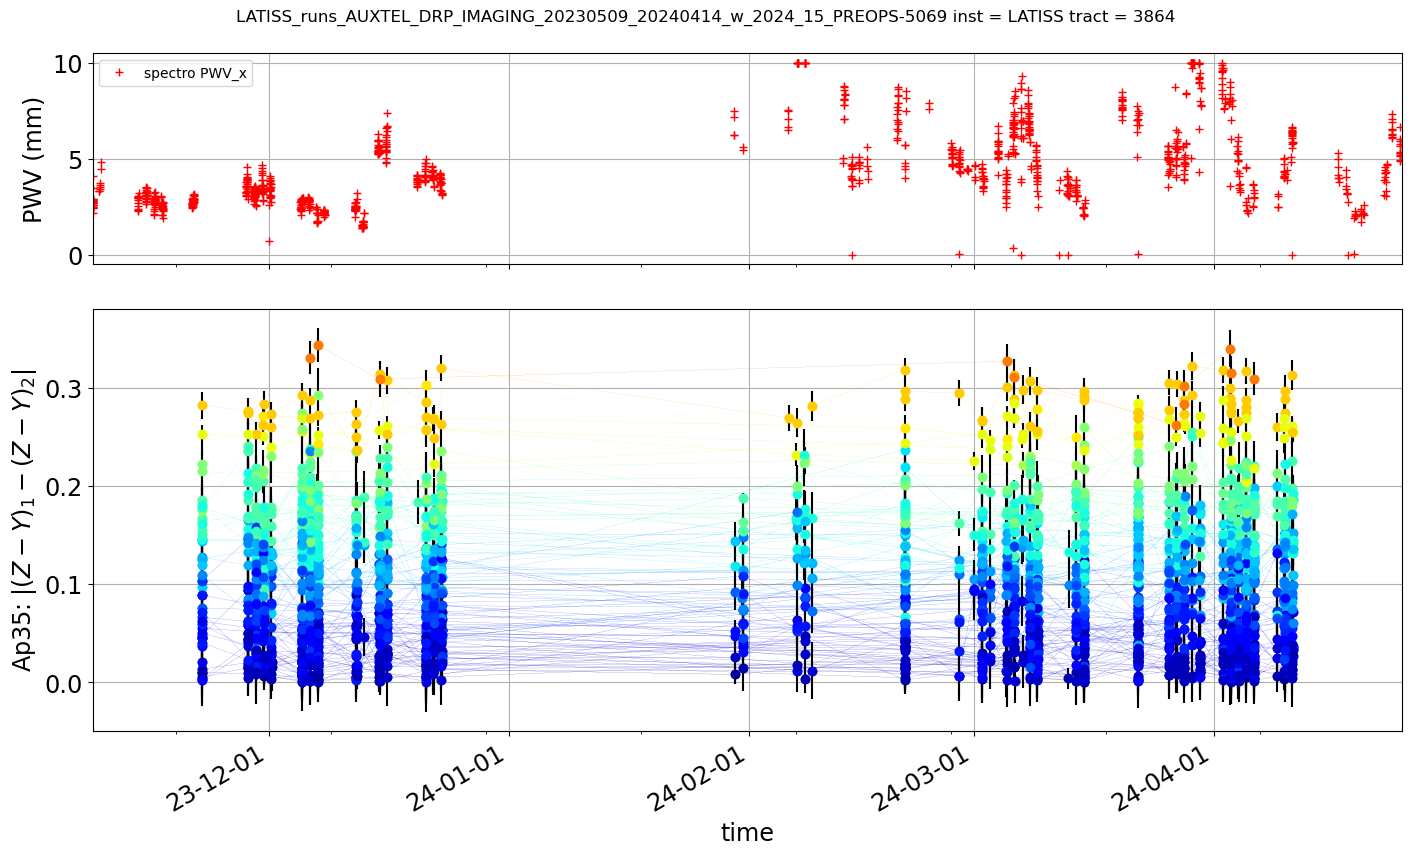

In [47]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
#fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)

fig = plt.figure(figsize=(14,8),constrained_layout=True)
gs = GridSpec(2, 1, wspace=0, hspace=0.1, height_ratios=[1,2],figure=fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)



df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")

all_tmin = []
all_tmax = []

for idx,df_col in enumerate(all_colors_diff):
    the_color = all_colors[idx]

    if(len(df_col)>5):
        df_col.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c=the_color,lw=0.1,grid=True,legend=False)
        ax2.errorbar(df_col.time1,df_col.apcol12_s12,yerr=df_col.apcol12Err_s12,color=the_color,ecolor="k",fmt="o")

        tmin = df_col["time1"].min()
        tmax = df_col["time1"].max()
        dt = tmax-tmin
        tmin = tmin-dt/10
        tmax = tmax+dt/10
        all_tmin.append(tmin)
        all_tmax.append(tmax)

ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)

the_tmin=np.min(all_tmin)
the_tmax=np.max(all_tmax)

ax2.set_xlim(the_tmin,the_tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
#ax2.legend(loc="upper left")
ax2.set_ylabel("Ap35: $|(Z-Y)_1-(Z-Y)_2|$")

title = suptitle
plt.suptitle(title,y=1.05)